In this notebook, we will be implementing the approach of Deep Kolarization as described in research paper https://arxiv.org/pdf/1712.03400.pdf

In [0]:
#Import block

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torchvision.utils import save_image

import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

import glob
import os
import pathlib

from PIL import Image
from skimage import color

from random import shuffle

import torch.optim as optim

import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
local_path = '/content/data'
local_path_test = '/content/test_data'
global_path = '/content/drive/My Drive/Machine Learning - Google Colab/Flower Dataset/ML_Save_Data'
image_format = 'jpg'
image_size = 256

In [0]:
class CustomDataset(Dataset):
    def __init__(self, path, image_size, image_format = 'png'):
        
        self.root = path
        self.image_size = image_size
        
        path_loc = pathlib.Path(path)
        if(not path_loc.exists()):
            raise Exception('The path provided is incorrect!')
        
        searchstring = os.path.join(path,'*.'+image_format)
        list_of_images = glob.glob(searchstring)
        
        self.image_paths = list_of_images
    
    def __getitem__(self, index):
        file_path = self.image_paths[index]
        img =  self.load_image(file_path)
        img = img.resize((self.image_size, self.image_size))
        img_np = np.array(img)
        
        #Scale the values to range -1 to 1
        img_np = (img_np - 127.5)/127.5
        
        lab_img = color.rgb2lab(img)
        
        img_np = np.transpose(img_np,(2,0,1))
        lab_img = np.transpose(lab_img, (2,0,1))
        
        img_l = lab_img[0,:,:]/100
        size = img_l.shape
        
        return (torch.DoubleTensor(img_l).view(-1,size[0],size[1]), torch.DoubleTensor(img_np))
        
    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, file_path):
        with open(file_path,'rb') as file:
            with Image.open(file) as img:
                return img.convert('RGB')
    
    def __str__(self):
        return 'Dataset details are - \nRoot Location : {}\nImage Size : {}\nSize : {}\nTransforms : ToTensor and Normalize (RGB Image from -1 to 1 and Grayscale Image from 0 to 1)'.format(self.root,self.image_size, self.__len__())

In [0]:
path = global_path
path = local_path

In [0]:
# -*- coding: utf-8 -*-

import torch
from random import shuffle

class Dataloader:
    def __init__(self, path, image_size, batch_size = 16, image_format = 'png', validation_required = (False, 0.2)):
        self.path = path
        self.image_size = image_size
        self.image_format = image_format
        self.validation_req = validation_required
        self.batch_size = batch_size
    
    def get_data_loader(self):
        dataset = CustomDataset(self.path, self.image_size, self.image_format)
        print(dataset)
        size = len(dataset)
        
        train_index = list(range(size))
        valid_index = []
        
        if self.validation_req[0]:
            train_size = int(size*(1- self.validation_req[1]))
            indexes = list(range(size))
            shuffle(indexes)
            train_index = indexes[0:train_size]
            valid_index = indexes[train_size:]
        
        train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
        valid_sampler = torch.utils.data.SubsetRandomSampler(valid_index)
        
        trainloader = None
        validloader = None
        if (len(valid_index) == 0):
            trainloader = torch.utils.data.DataLoader(dataset, shuffle= True, batch_size= self.batch_size)
        else:
            trainloader = torch.utils.data.DataLoader(dataset, sampler= train_sampler, batch_size= self.batch_size)
            validloader = torch.utils.data.DataLoader(dataset, sampler= valid_sampler, batch_size= self.batch_size)
        
        return (trainloader, validloader)

In [21]:
loader = Dataloader(path, image_size, image_format= image_format )
trainloader, validloader = loader.get_data_loader()

Dataset details are - 
Root Location : /content/data
Image Size : 256
Size : 1354
Transforms : ToTensor and Normalize (RGB Image from -1 to 1 and Grayscale Image from 0 to 1)


In [25]:
test_loader = Dataloader(local_path_test, image_size, image_format= image_format )
test_trainloader, test_validloader = test_loader.get_data_loader()

Dataset details are - 
Root Location : /content/test_data
Image Size : 256
Size : 28
Transforms : ToTensor and Normalize (RGB Image from -1 to 1 and Grayscale Image from 0 to 1)


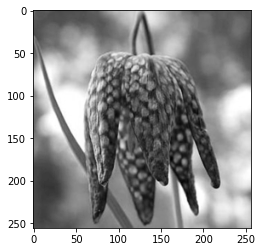

In [11]:
plt.imshow(next(iter(trainloader))[0][5][0],cmap='gray')

# Data Loading has been done!

In [0]:
class Discriminator(nn.Module):
    def __init__(self, image_size = 224, leaky_relu = 0.2):
        
        super(Discriminator, self).__init__()
        
        self.leaky_relu = nn.LeakyReLU(leaky_relu)
        self.sigmoid = nn.Sigmoid()
        
        #Considering input to be 224
        self.layer_1 = nn.Conv2d(3, 32, 4, padding= 1, stride= 2)
        self.layer_1_bn = nn.BatchNorm2d(32)
        #Output size is batch_size X 32 X 112 X 112
        
        self.layer_2 = nn.Conv2d(32, 64, 4, padding= 1, stride= 2)
        self.layer_2_bn = nn.BatchNorm2d(64)
        #Output size is batch_size X 64 X 56 X 56
        
        self.layer_3 = nn.Conv2d(64, 128, 4, padding= 1, stride= 2)
        self.layer_3_bn = nn.BatchNorm2d(128)
        #Output size is batch_size X 128 X 28 X 28
        
        self.layer_4 = nn.Conv2d(128, 256, 4, padding= 1, stride= 2)
        self.layer_4_bn = nn.BatchNorm2d(256)
        #Output size is batch_size X 256 X 14 X 14
        
        self.layer_5 = nn.Conv2d(256, 512, 4, padding= 1, stride= 2)
        self.layer_5_bn = nn.BatchNorm2d(512)
        #Output size is batch_size X 512 X 7 X 7
        
        self.layer_6 = nn.Conv2d(512,1, int(image_size/32), padding= 0, stride= 1)
        
        self._initialize_weights()
    
    def forward(self, x):
        #Considering x to be of shape (batch_size X 3 X image_size X image_size)
        x = self.leaky_relu(self.layer_1_bn(self.layer_1(x)))
        
        x = self.leaky_relu(self.layer_2_bn(self.layer_2(x)))
        
        x = self.leaky_relu(self.layer_3_bn(self.layer_3(x)))
        
        x = self.leaky_relu(self.layer_4_bn(self.layer_4(x)))
        
        x = self.leaky_relu(self.layer_5_bn(self.layer_5(x)))
        
        x = self.sigmoid(self.layer_6(x))
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, std= 0.02)
                nn.init.constant_(m.bias.data, 0)
                

In [0]:
class Generator(nn.Module):
    def __init__(self, image_size = 224):
        super(Generator, self).__init__()
        
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
        #Input is of shape(1 X 1 X image_size X image_size)
        self.layer_1 = nn.Conv2d(1,64, 4, padding= 1, stride= 2)
        self.layer_1_bn = nn.BatchNorm2d(64)
        #Output is of shape (1 X 64 X 112 X 112)
        
        self.layer_2 = nn.Conv2d(64,128, 4, padding= 1, stride= 2)
        self.layer_2_bn = nn.BatchNorm2d(128)
        #Output is of shape (1 X 64 X 56 X 56)
        
        self.layer_3 = nn.Conv2d(128,256, 4, padding= 1, stride= 2)
        self.layer_3_bn = nn.BatchNorm2d(256)
        #Output is of shape (1 X 64 X 28 X 28)
        
        self.layer_4 = nn.Conv2d(256,512, 4, padding= 1, stride= 2)
        self.layer_4_bn = nn.BatchNorm2d(512)
        #Output is of shape (1 X 64 X 14 X 14)
        
        self.layer_5 = nn.Conv2d(512,512, 4, padding= 1, stride= 2)
        self.layer_5_bn = nn.BatchNorm2d(512)
        #Output is of shape (1 X 64 X 7 X 7)
        
        self.layer_6 = nn.ConvTranspose2d(512, 512, 4, padding= 1, stride= 2)
        self.layer_6_bn = nn.BatchNorm2d(512)
        #Ouput shape 14 X 14
        
        self.layer_7 = nn.ConvTranspose2d(512, 256, 4, padding= 1, stride= 2)
        self.layer_7_bn = nn.BatchNorm2d(256)
        #Ouput shape 28 X 28
        
        self.layer_8 = nn.ConvTranspose2d(256, 128, 4, padding= 1, stride= 2)
        self.layer_8_bn = nn.BatchNorm2d(128)
        #Output shape 56 X 56
        
        self.layer_9 = nn.ConvTranspose2d(128, 64, 4, padding= 1, stride= 2)
        self.layer_9_bn = nn.BatchNorm2d(64)
        #Ouput shape 112 X 112
        
        self.layer_10 = nn.ConvTranspose2d(64, 3, 4, padding= 1, stride= 2)
        #Output shape is 224 X 224
        
        self._initialize_weights()
    
    def forward(self, x):
        
        x = self.relu(self.layer_1_bn(self.layer_1(x)))
        store_1 = x
        
        x = self.relu(self.layer_2_bn(self.layer_2(x)))
        store_2 = x
        
        x = self.relu(self.layer_3_bn(self.layer_3(x)))
        store_3 = x
        
        x = self.relu(self.layer_4_bn(self.layer_4(x)))
        store_4 = x
        
        x = self.relu(self.layer_5_bn(self.layer_5(x)))
        
        x = self.relu(self.layer_6_bn(self.layer_6(x)))
        x += store_4
        
        x = self.relu(self.layer_7_bn(self.layer_7(x)))
        x += store_3
        
        x = self.relu(self.layer_8_bn(self.layer_8(x)))
        x += store_2
        
        x = self.relu(self.layer_9_bn(self.layer_9(x)))
        x += store_1
        
        x = self.tanh(self.layer_10(x))
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, std= 0.02)
                nn.init.constant_(m.bias.data,0)

In [0]:
class Model:
    def __init__(self, base_path = '', epochs = 10, learning_rate = 0.0002, image_size = 224, leaky_relu = 0.2, betas = (0.5,0.999), lamda = 100, image_format = 'png'):
        self.image_size = image_size
        self.leaky_relu_threshold = leaky_relu
        
        self.epochs = epochs
        self.lr = learning_rate
        self.betas = betas
        self.lamda = lamda
        self.base_path = base_path
        self.image_format = image_format
        self.count = 1
        
        self.gen = None
        self.dis = None
        
        self.gen_optim = None
        self.dis_optim = None
        
        self.device = self.get_device()
    
    def get_device(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print('Using device:', device)
        
        #Additional Info when using cuda
        if device.type == 'cuda':
            print(torch.cuda.get_device_name(0))
            print('Memory Usage -')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
            return device
        else:
            return None
    
    def initialize_model(self, model_type = 'unet'):
        
        if(model_type == 'unet'):
            self.gen = Generator(image_size= self.image_size)
            self.dis = Discriminator(image_size= self.image_size, leaky_relu= self.leaky_relu_threshold)
            
            self.gen.double()
            self.dis.double()
            
            if(self.device != None):
                self.gen.cuda()
                self.dis.cuda()
            
            self.gen_optim = optim.Adam(self.gen.parameters(), lr= self.lr, betas= self.betas)
            self.dis_optim = optim.Adam(self.dis.parameters(), lr= self.lr, betas= self.betas)
            print('Model Initialized !')
    
    def train_model(self, trainloader, save_model = (False, 25), display_test_image = (False, None, 25)):
        
        mean_loss = nn.BCELoss()
        l1_loss = nn.L1Loss()
        
        self.gen.train()
        self.dis.train()
        
        gen_loss = []
        dis_loss = []
        
        iterations = 1
        
        sample_img_test = None
        if display_test_image[0]:
            gray_test_images, rgb_test_images = next(iter(display_test_image[1]))
            sample_img_test = gray_test_images[0].view(1,1,self.image_size, self.image_size)
            if self.device != None:
                sample_img_test = sample_img_test.cuda()
                save_image((rgb_test_images[0].detach().cpu()+1)/2, '{}/real_img.{}'.format(self.base_path, self.image_format))
        
        running_gen_loss = 0
        running_dis_loss = 0

        for i in range(self.epochs):
            
            for gray_img, real_img in trainloader:
                
                batch_size = len(gray_img)
                zero_label = torch.zeros(batch_size, dtype = torch.double)
                one_label = torch.ones(batch_size, dtype = torch.double)
  
                if self.device != None:
                    gray_img = gray_img.cuda()
                    real_img = real_img.cuda()
                    zero_label = zero_label.cuda()
                    one_label = one_label.cuda()
                    
                #Discriminator loss
                self.dis_optim.zero_grad()
                fake_img = self.gen(gray_img)
                
                dis_real_loss = mean_loss(self.dis(real_img), one_label)
                dis_fake_loss = mean_loss(self.dis(fake_img), zero_label)
                    
                total_dis_loss = dis_fake_loss + dis_real_loss
                total_dis_loss.backward()
                self.dis_optim.step()
                    
                #Generator loss
                self.gen_optim.zero_grad()
                
                fake_img = self.gen(gray_img)
                gen_adv_loss = mean_loss(self.dis(fake_img),one_label)
                gen_l1_loss = l1_loss(fake_img.view(batch_size, -1), real_img.view(batch_size, -1))
            
                total_gen_loss = gen_adv_loss + self.lamda*gen_l1_loss
                total_gen_loss.backward()
                self.gen_optim.step()
                    
                running_dis_loss += total_dis_loss.item()
                running_gen_loss += total_gen_loss.item()                                
                
                if(display_test_image[0] and iterations % display_test_image[2] == 0):
                    self.gen.eval()
                    out_result = self.gen(sample_img_test)
                    out_result = out_result.detach().cpu()
                    out_result = (out_result[0] + 1)/2
                    save_image(out_result,'{}/iteration_{}.{}'.format(self.base_path, iterations, self.image_format))
                    self.gen.train()
                iterations += 1
                
                if(save_model[0] and iterations % save_model[1] == 0):
                    self.save_checkpoint('checkpoint_iter_{}'.format(iterations), 'unet')
                
                if (iterations % 20 == 0):
                    running_gen_loss /= 20.0
                    running_dis_loss /= 20.0
                    print('Losses after iteration : {} : Discriminator Loss : {} and Generator Loss : {}'.format(iterations, running_dis_loss, running_gen_loss))
                    gen_loss.append(running_gen_loss)
                    dis_loss.append(running_dis_loss)
                    running_gen_loss = 0
                    running_dis_loss = 0
        
        plt.plot(gen_loss, label = 'Generator Loss')
        plt.plot(dis_loss, label = 'Discriminator Loss')
        plt.legend()
        plt.show()
        
        return (gen_loss, dis_loss)
    
    def evaluate_model(self, loader, save_filename, no_of_images = 1):
        
        counter_images_generated = 0
        while(counter_images_generated < no_of_images):
          gray, rgb = next(iter(loader))
          test_img = gray[5]
          real_img = rgb[5]
          
          if(self.device != None):
              test_img = test_img.cuda()
          
          if(self.gen == None or self.dis == None):
              raise Exception('Model has not been initialized!')
          
          filename = '{}/{}_{}.{}'.format(self.base_path, save_filename, self.count, self.image_format)
          real_filename = '{}/{}_{}_real.{}'.format(self.base_path, save_filename, self.count, self.image_format)
          real_gray_filename = '{}/{}_{}_real_gray.{}'.format(self.base_path, save_filename, self.count, self.image_format)
          self.count += 1
          
          self.gen.eval()
          test_img = test_img.view(1,1,self.image_size, self.image_size)
          out = self.gen(test_img)
          out = out.detach().cpu()
          out = (out+1)/2
          save_image(out, filename)
          
          gray_img = gray[5].detach().cpu()
          save_image(gray_img, real_gray_filename)

          real_img = (real_img.detach().cpu() +1)/2
          save_image(real_img, real_filename)

          counter_images_generated +=1
    
    def change_params(self, epochs = None, learning_rate = None, leaky_relu = None, betas = None, lamda = None):
        if(epochs != None):
            self.epochs = epochs
            print('Changed the number of epochs!')
        if(learning_rate != None):
            self.lr = learning_rate
            print('Changed the learning rate!')
        if(leaky_relu != None):
            self.leaky_relu_threshold = leaky_relu
            print('Changed the threshold for leaky relu!')
        if(betas != None):
            self.betas = betas
            print('Changed the betas for Adams Optimizer!')
        if(betas != None or learning_rate != None):
            self.gen_optim = optim.Adam(self.gen.parameters(), lr= self.lr, betas= self.betas)
            self.dis_optim = optim.Adam(self.dis.parameters(), lr= self.lr, betas= self.betas)
            
        if(lamda != None):
            self.lamda = lamda
            print('Lamda value has been changed!')
    
    def save_checkpoint(self, filename, model_type = 'unet'):
        if(self.gen == None or self.dis == None):
            raise Exception('The model has not been initialized and hence cannot be saved !')
        
        filename = '{}/checkpoints/{}.pth'.format(self.base_path, filename)
        save_dict = {'model_type': model_type, 'dis_dict':self.dis.state_dict(), 'gen_dict': self.gen.state_dict(), 'lr': self.lr,
                    'epochs' : self.epochs, 'betas': self.betas, 'image_size':self.image_size, 
                     'leaky_relu_thresh' : self.leaky_relu_threshold, 'lamda' : self.lamda, 'base_path': self.base_path, 
                     'count' : self.count, 'image_format': self.image_format}
        
        torch.save(save_dict, filename)
        
        print('The model checkpoint has been saved !')
    
    def load_checkpoint(self, filename):
        filename = '{}/checkpoints/{}.pth'.format(self.base_path, filename)
        if(not pathlib.Path(filename).exists()):
            raise Exception('This checkpoint does not exist!')
        
        self.gen = None
        self.dis = None
        
        save_dict = torch.load(filename)
        
        self.betas = save_dict['betas']
        self.image_size = save_dict['image_size']
        self.epochs = save_dict['epochs']
        self.leaky_relu_threshold = save_dict['leaky_relu_thresh']
        self.lamda = save_dict['lamda']
        self.lr = save_dict['lr']
        self.base_path = save_dict['base_path']
        self.count = save_dict['count']
        self.image_format = save_dict['image_format']
        self.device = self.get_device()
        
        self.initialize_model(model_type= save_dict['model_type'])
        
        self.gen.load_state_dict(save_dict['gen_dict'])
        self.dis.load_state_dict(save_dict['dis_dict'])
        
        print('The model checkpoint has been restored')

In [35]:
model = Model(base_path = global_path, image_size= image_size, image_format = image_format)

Using device: cuda
Tesla P100-PCIE-16GB
Memory Usage -
Allocated: 0.1 GB
Cached:    0.3 GB


In [0]:
model.initialize_model()

Model Initialized !
Changed the number of epochs!
Changed the learning rate!
Lamda value has been changed!


In [0]:
model.change_params(epochs=55)
model.change_params(learning_rate = 0.0001)
model.change_params(lamda = 100)

Changed the number of epochs!
Changed the learning rate!
Lamda value has been changed!


In [36]:
model.load_checkpoint('checkpoint_iter_8600')

Using device: cuda
Tesla P100-PCIE-16GB
Memory Usage -
Allocated: 0.1 GB
Cached:    0.3 GB
Model Initialized !
The model checkpoint has been restored


In [0]:
model.evaluate_model(test_trainloader, 'test', 28)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Losses after iteration : 20 : Discriminator Loss : 1.1385328290710433 and Generator Loss : 7.983951245908706
Losses after iteration : 40 : Discriminator Loss : 1.1791269560896362 and Generator Loss : 8.842950530540321
Losses after iteration : 60 : Discriminator Loss : 1.141373723546566 and Generator Loss : 8.864234235289034
Losses after iteration : 80 : Discriminator Loss : 1.1533667138655503 and Generator Loss : 8.849239966038054
The model checkpoint has been saved !
Losses after iteration : 100 : Discriminator Loss : 1.1529518249174844 and Generator Loss : 8.624198818874515
Losses after iteration : 120 : Discriminator Loss : 1.136410241502977 and Generator Loss : 8.854959778428116
Losses after iteration : 140 : Discriminator Loss : 1.2213811358704876 and Generator Loss : 8.379893908203428
Losses after iteration : 160 : Discriminator Loss : 1.2154852408543102 and Generator Loss : 8.891314742529246
Losses after iteration : 180 : Discriminator Loss : 1.1186936115611217 and Generator Los

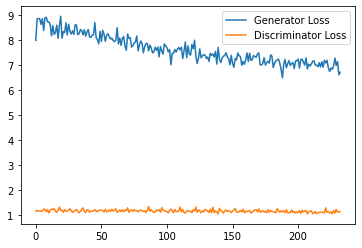

([7.983951245908706,
  8.842950530540321,
  8.864234235289034,
  8.849239966038054,
  8.624198818874515,
  8.854959778428116,
  8.379893908203428,
  8.891314742529246,
  8.90380472844917,
  8.726989512398168,
  8.725664562005345,
  8.603702788893841,
  8.169645918125257,
  8.575522025439897,
  8.223437585831816,
  8.295579713243173,
  8.593352170377775,
  8.071740046335284,
  8.582496217087815,
  8.951402723791599,
  8.070426964119097,
  8.339351351522993,
  8.29911795049147,
  8.688150824753505,
  8.203497198150961,
  8.627515396005926,
  8.351189813509219,
  8.239658526460037,
  8.366709969764672,
  8.224361400358934,
  8.611375703134822,
  8.59807147685161,
  8.216461104563248,
  8.2477677758969,
  8.421321511728754,
  8.374502570543779,
  8.207172948721729,
  8.412889241211474,
  8.153851106584241,
  8.316568355315937,
  8.416644996670723,
  8.116093372164817,
  8.107469910831213,
  8.19941403648952,
  8.20984921425585,
  8.702314874644848,
  8.092115025690441,
  8.009645282658944,

In [23]:
model.train_model(trainloader, save_model= (True, 100), display_test_image=(True, trainloader, 20))

In [0]:
drive.flush_and_unmount()